## Exploratory Data Analysis

This notebook explores the structure of the PHEME Rumor Non-Rumor dataset to find potentially useful features for a classifier.

In [1]:
# Import dependencies for this notebook
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from lib.util import fetch_tweets

%matplotlib inline

plt.style.use("ggplot")
mpl.rcParams["figure.figsize"] = [17, 10]

colorPal = {"rumor": "dodgerblue", "nonrumor": "slategray"}

gw = fetch_tweets("germanwings-crash")

def agg(x):
    fields = {
        "source_count": np.count_nonzero(x["is_source_tweet"]),
        "reply_count": np.count_nonzero(x["is_source_tweet"] == 0),
        "rumor_count": np.count_nonzero(x["is_rumor"]),
        "nonrumor_count": np.count_nonzero(x["is_rumor"] == 0),
        "thread_count": len(np.unique(x["thread"])),
    }
    return pd.Series(fields, index=["source_count", "reply_count", "rumor_count", "nonrumor_count", "thread_count"])

summary = gw.groupby("event").apply(agg)
summary

,source_count,reply_count,rumor_count,nonrumor_count,thread_count
event,,,,,
germanwings-crash,469,4020,2494,1995,469


In [2]:
def graph_bool_col(df, title):
    titlesize = 18
    ax = df.plot(kind="bar",
                 color=["dodgerblue","slategray"],
                 fontsize=13)
    ax.set_alpha(0.8)
    ax.set_title(title, fontsize=titlesize)
    ax.set_ylabel("Number of Tweets", fontsize=titlesize)
    ax.set_xlabel("PHEME Event", fontsize=titlesize)
    ax.set_xticklabels(["Geranwings Crash"], rotation="horizontal")

    for i in ax.patches:
        ax.text(i.get_x() + (i.get_width() / 2.2), i.get_height() - 200, \
               str(round(i.get_height(), 2)), fontsize=12, color="white")

## Thread Structures

For each event, most of the tweets are replies to other tweets.

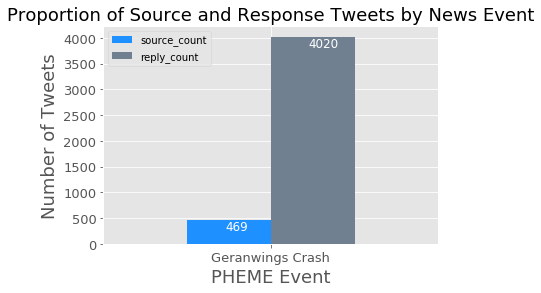

In [5]:
graph_bool_col(summary[["source_count", "reply_count"]], "Proportion of Source and Response Tweets by News Event")

## Exploring the Conversational Network Structure
Tweets in the PHEME dataset are organized into threads, proxies for conversations threads. When one tweet replies to another, it constitutes a thread. Since the vast majority of tweets in this dataset are replies to other tweets, we examined the distribution of *thread length*, the number of individual tweets in a thread. 

The boxplot below shows that while most tweets in this dataset are replies to other tweets, the average length of a thread is around TK tweets across all events.

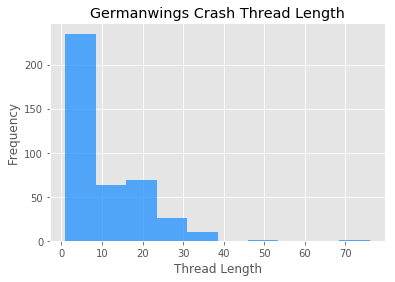

In [6]:
relations = gw[gw["is_source_tweet"] == False][["thread", "user_id", "in_reply_user", "tweet_id", "in_reply_tweet", "is_rumor"]]

thread_lengths = [
    relations[["thread", "tweet_id"]].groupby("thread").agg(len)['tweet_id']
]

thread_lengths_list = [ thread.tolist() for thread in thread_lengths ]

for event in thread_lengths:
    event.plot(kind="hist", color="dodgerblue", alpha=0.75)
    plt.title("Germanwings Crash Thread Length")
    plt.xlabel("Thread Length")

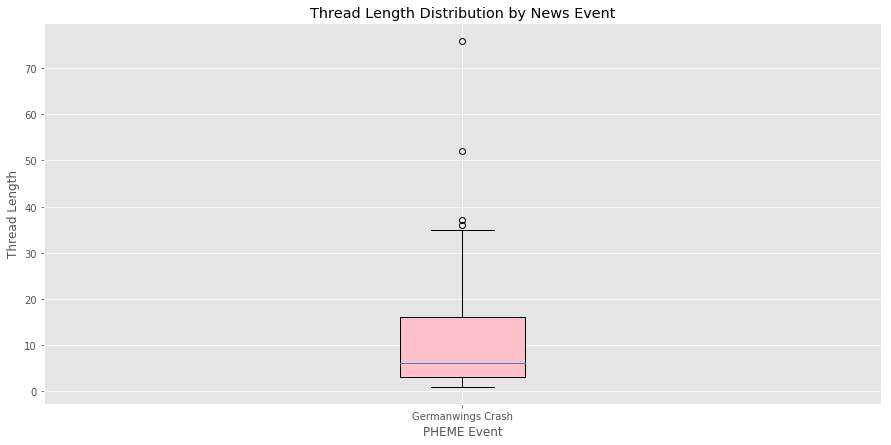

In [7]:
fig, axes = plt.subplots(figsize=(15,7))

bplot = axes.boxplot(thread_lengths_list, patch_artist=True)

for patch, color in zip(bplot["boxes"], ["pink"]):
    patch.set_facecolor(color)

axes.set_xlabel("PHEME Event")
axes.set_ylabel("Thread Length")
axes.set_title("Thread Length Distribution by News Event")

plt.setp(axes, xticks=[y+1 for y in range(len(thread_lengths_list))], xticklabels=["Germanwings Crash"])

plt.show()

## Proportion of Rumor to Non-Rumor

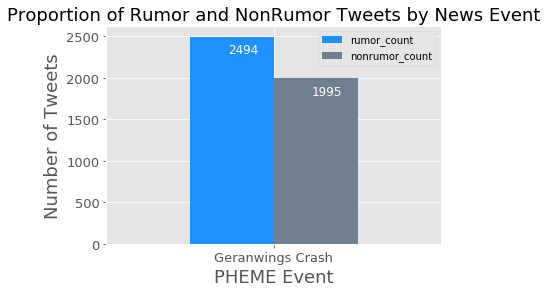

In [8]:
graph_bool_col(summary[["rumor_count", "nonrumor_count"]], "Proportion of Rumor and NonRumor Tweets by News Event")

## Combining Structure and Rumor


In [9]:
def graph_connections(edgelist, title):
    G = nx.from_pandas_edgelist(edgelist, "user_id", "in_reply_user")
    pos = nx.layout.spring_layout(G)

    rumor_to_color = lambda rumor : colorPal['rumor'] if rumor == True else colorPal['nonrumor']
    node_colors = [rumor_to_color(val) for val in edgelist['is_rumor']]

    nodes = nx.draw_networkx_nodes(G, pos,
                               node_color=node_colors,
                               node_size=10)

    edges = nx.draw_networkx_edges(G, pos,
                                arrowsize=30, 
                                width=1)

    ax = plt.gca()
    ax.set_axis_off()
    ax.set_title(title)

    legend_elements = [
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['rumor'], label="Rumor", color='slategray', markersize=10),
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['nonrumor'], label="Non-Rumor", color='slategray', markersize=10)    
    ]

    ax.legend(handles=legend_elements)
    plt.show()

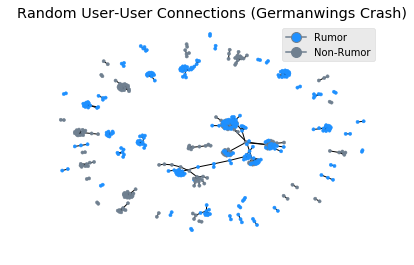

In [10]:
random_threads = relations[["thread", "user_id"]] \
    .groupby("thread") \
    .agg(pd.Series.nunique) \
    .sample(50, random_state=2)
random_connections = relations[relations.thread.isin(list(random_threads.index))]
graph_connections(random_connections, "Random User-User Connections (Germanwings Crash)")

We start to see some interesting patterns in the user-to-user response network in a thread.

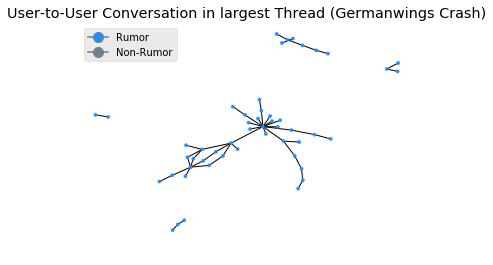

In [12]:
largest_threads = relations[["thread", "user_id"]] \
    .groupby("thread") \
    .agg(pd.Series.nunique) \
    .sort_values("user_id", ascending=False) \
    [0:1]

dense_connections = relations[relations["thread"].isin(list(largest_threads.index))]
graph_connections(dense_connections, "User-to-User Conversation in largest Thread (Germanwings Crash)")

This visualization lends itself to two possibly interesting features:

1. The number of components per thread.
2. The diameter of the largest component.
